In [ ]:
import numpy as np
import torch
from torch import nn
torch.manual_seed(0)

from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive/GAN Stuff/models')
sys.path.append('/content/drive/MyDrive/GAN Stuff/functions')

from models.WGAN import *
from functions.data_functions import *
from functions.models_functions import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cp -av /content/drive/MyDrive/'Giraffa Analytics'/'MRI-Blur-Detection'/'Data' 'preprocessed slices'

'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data' -> 'preprocessed slices'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices' -> 'preprocessed slices/preprocessed slices'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices/slice_14_NC247_nomotion.npy' -> 'preprocessed slices/preprocessed slices/slice_14_NC247_nomotion.npy'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices/slice_14_NC248_motion.npy' -> 'preprocessed slices/preprocessed slices/slice_14_NC248_motion.npy'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices/slice_14_NC248_nomotion.npy' -> 'preprocessed slices/preprocessed slices/slice_14_NC248_nomotion.npy'
'/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection/Data/preprocessed slices/slice_14_NC249_motion.npy' -> 'preprocessed slices/preprocessed slices/slice_14_NC249_motion.npy'
'/content/drive/MyDrive/Giraffa 

In [ ]:
img_shape = (1, 126, 126)

In [ ]:
images = get_images(img_shape=(1,126,126))

In [ ]:
len(images)

609

In [ ]:
n_epochs = 70
z_dim = 128
display_step = 100
batch_size = 2
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'



In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

  0%|          | 0/70 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100: Generator loss: 0.20165927218040453, critic loss: 0.056816287808120196


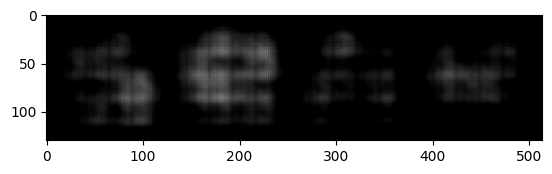

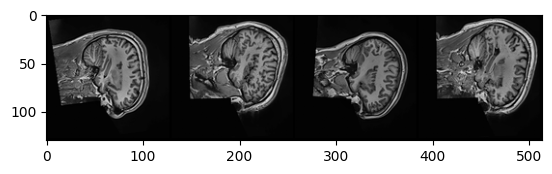

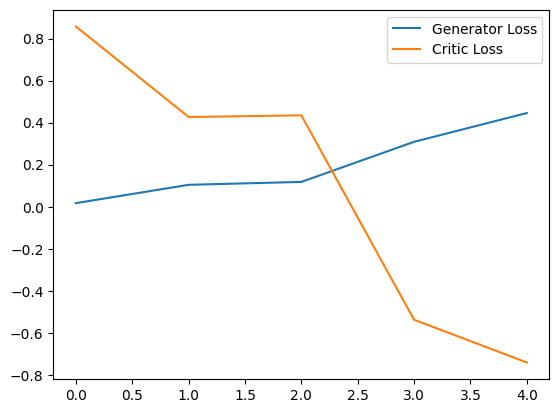

  0%|          | 0/70 [00:18<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
batch_scaler=2
for epoch in tqdm(range(n_epochs)):
    # Dataloader returns the batches
    if epoch % 20 == 0:
      if batch_size == 32:
        batch_scaler = 1
        batch_size = 16
      batch_size = int(batch_size*batch_scaler)
      dataloader = DataLoader(CustomDataset(images), batch_size=batch_size, shuffle=True)
    for real in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

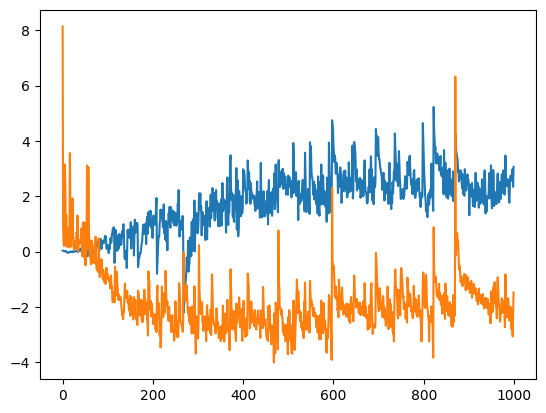

In [ ]:
plt.plot(generator_losses[:1000])
plt.plot(critic_losses[:1000])